## Outline:

- Naive Bayes with Iris dataset with real-valued features (as opposed to binary valued in class)
  - Ask to complete code in certain portions
  - Give wrong code (prior calculation) and ask to correct it
  - Ask to perform data analysis with size of training set for different classifiers
- Logistic regression with real valued features. 
  - implementing costfunction and gradient descent from scratch
  - Visualizing learned boundary 
- Designing, visualizing, and testing classification metrics from scratch (AUC, ROC, Acc, IOU etc.)


### Question 1: Naive Bayes for Classifying Real-Valued Data

In Lecture 4 of class, you learnt about the Naive Bayes classification algorithm to classify discrete-valued feature data. Here, we extend this to real-valued data with the popular Iris dataset provided by the `sklearn` library. Before we do that, a quick revision of the algorithm is in order.

Bayes theorem lies at the heart of Naive Bayes, connecting the posterior predictive distribution of the labels to the likelihood of the data features, as shown by the following equations:

\begin{align}
P(y=c|\mathbf{x}) &= \frac{P(\mathbf{x}|y=c) \times P(y=c)}{\sum_{k=1}^{C}P(\mathbf{x}|y=k)\times P(y=k)} \\ \\
                  &= \frac{P(\mathbf{x}|y=c) \times P(y=c)}{P(\mathbf{x})}
\end{align}

where $\mathbf{x} = \begin{bmatrix}x_{1}\\x_{2}\\\vdots\\x_{d} \end{bmatrix}\in\mathbb{R}^{d}$ and $y\in\{c_{i}\}^{K}_{i=1}$, $\mathbf{x}$ being a _d_-dimensional feature vector for a data point and $y$ being the corresponding label taking on values from the set $\{c_{i}\}^{K}_{i=1}$. The algorithm works by computing the posterior, $P(y=c|\mathbf{x})$ for each one of the $K$ classes and picking out the label corresponding to the most likely outcome. In a nutshell, this is akin to predicting if it rained on not on a given day by analyzing the likelihoods of the grass getting wet by all of the possible ways e.g., gardner watering the plants, morning dew, rain etc., keeping also in mind certain prior beliefs about the problem e.g., it tends to rain a lot in the area and the gardner rarely shows up etc. 

Since the denominator is merely a scaling constant and does not depend on $y$, we usually ignore that for our purposes. The above formulation for Naive Bayes then reduces to:

\begin{align}
Posterior  &\propto Likelihood \times Prior\\ \\
P(y=c|\mathbf{x}) &\propto P(\mathbf{x}|y=c) \times P(y=c) 
\end{align}


Since $P(\mathbf{x})$ is in general a multivariate distribution of many features, modeling it is not an easy task. This is where the naive assumption comes into play&mdash;it assumes all features are conditionally independent of each other. This is ofcourse a gross simplification of the problem but it tends to work surprisingly well in many cases. The above formulation with the independence assumption then becomes:

$$P(y=c|\mathbf{x}) \propto \prod^{d}_{j=1}P(x_{j}|y=c) \times P(y=c)$$

Each of the $P(x_{j}|y=c)$ terms conditions a feature variable on a target label via a probability distribution parameterized by certain parameters, $\mathbf{\theta}$. These parameters could be the mean and standard deviation of a gaussian distribtuion in case of real-valued features, or they could just be the success rate in a bernoulli distribution in case of binary valued $x_{j}$. In any case, these parameters are learnt during the training process from the labeled training data. It would then be more appropriate to write the above formulation as:

$$P(y=c|\mathbf{x}) \propto \prod^{d}_{j=1}P(x_{j}|y=c, \theta_{jc}) \times P(y=c),$$

where $\theta_{jc}$ represents the parameter set characterizing the conditional distribution of feature $j$ on label $c$. The prior $P(y=c)$ may similarly be learnt either from the training data. Finally, the inference phase is carried out by obtaining the likelihoods of all test data points by sampling them from the parameterized distributions learnt earlier, and then maximizing the posterior over all possible labels, as shown below:

$$\hat{y} = \underset{c}{\operatorname{argmax}} \prod^{d}_{j=1}P(x^{test}_{j}|y=c, \theta_{jc}) \times P(y=c)$$

This is called the Maximum a posteriori (MAP) estimation. Alternatively, the prior may be set to be uniform, in which case the formulation reduces to just maximizing the conditional data likelihoods, in what is known as the Maximum Likelihood Estimation (MLE). 

An issue that frequently occurs with long chains of probability products is that of numerical underflow i.e., the computer is unable to handle extremely high levels of precision required and forces the result to just be zero. This is often circumvented by computing the logs of the probabilities rather than the raw probabilities themselves, turning the product chain into a summation chain. The maximization may then be carried out in the log space. This is made possible by the monotonic behavior of the log function&mdash;what minimizes or maximizes $f(x)$ also minimizes or maximizes respectively $\text{log} f(x)$. The restructured formulation is given below:

$$\hat{y} = \underset{c}{\operatorname{argmax}} \sum^{d}_{j=1}\text{log} P(x^{test}_{j}|y=c, \theta_{jc}) +  \text{log}P(y=c)$$

To obtain the posteriors back, one may always exponentiate the expression on the right and normalize afterwards. 

In this exercise, you are going to implement your very own Naive Bayes class, with its `fit()` and `predict()` functions, among others. We will work with the iris dataset as an example, but the class should be able to take as input any other real valued feature data of any number of features and training examples, and be able to predict classes based on the MAP principle for unseen test data, as well as return the normalized posterior probabilities. Since we are working with real-valued data, we are going to impose the conditional feature distributions to be gaussians parameterized by mean ($\mu$) and variance ($\sigma$) parameters. Carefully read the questions below and answer them appropriately.

**_a)_** For a gaussian conditional likelihood form, $P(x_{j}|y=c)= \mathcal{N}(\mu_{jc}, \sigma_{jc})$, write down the form of the likelihood obtained after applying the log function to it. In other words, what is $\text{log} P(x_{j}|y=c)$? Write an expression for this functional form in the place indicated in the code below. 

**_b)_** Given a $N\times D$ dimensional training data array, complete code below in the appropriate place indicated to compute the mean ($\mu$) and variance parameters. Simple estimators for the mean and variance of gaussians given sample data would be the mean and variance computed respectively on the corresponding sample populations i.e., $\hat{\mu}_{jc} = \frac{\sum^{N}_{i=1}x_{ij}\times \mathbb{1}_{y_{i}=c}}{N_{c}}$ and $\hat{\sigma}_{jc} = \frac{\sum^{N}_{i=1}(x_{ij} - \hat{\mu}_{jc})^{2}\times \mathbb{1}_{y_{i}=c}}{N_{c}}$. $\mu_{jc}, \sigma_{jc}$ refer to the mean and variance respectively of the $j-th$ feature variable in class $c$, $i$ refers to the training example number, and $\mathbb{1}_{cond}$ is the identity function that takes the value 1 when the $cond$ is true and 0 otherwise. You may compute these parameters however you want, including with numpy functions, provided you use them carefully. 

**_c)_** Also compute the priors $P(y=c)$ for all class labels. As before, the prior may simply be estimated as $P(y=c) = \frac{N_{c}}{N}$. Write code in the place indicated below.

**_d)_** Finally, using the parameters calculated above, perform inference on test data by computing the posterior probabilities for each point in the test set and then selecting the class corresponding to the highest posterior. 

Do not change the function definitions for the functions defined in the *MyNaiveBayes* class template below. They should take inputs and output results of the form indicated. You are free to add other internal functions and use them inside the class definition as you see convenient. However, that should not change the external code's structure, nor the shape and form of the outputs returned. **_Note_**: Any variable preceded by the `self.` keyword gets stored by the class structure and can be used and changed afterwards inside the class regardless of whether the function that first made it returns it or not.




In [ ]:
# implement naive bayes class for iris

import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class MyNaiveBayes:
    def __init__(self, X_train, y_train):
        """Function intializes the Naive Bayes class.
        
        Parameters:
        -----------
        X_train: ndarray of shape (N,D)
            Numpy array containing N training examples, each D dimensional.
        
        y_train: ndarray of shape (N,)
            Numpy array containing vector of ground truth classes for examples in X_train
        """
        
        self.X_train = X_train
        self.y_train = y_train
        
    
    def log_gaussian(self, x, mean, std):
        """Function computes log P(x) from a normal distribution specified by parameters mean and std.
        To be called during inference"""
        
        log_likelihood = # implement code to compute log gaussian value for conditional probabilities 
        
        return log_likelihood
    
    
    def fit(self):
        """Function computes likelihood parameters from training data in the training phase"""
                
        self.priors = # calculate class priors from train data
        
        # calculate per class data likelihoods
        self.feature_means = 
        self.feature_std = 
        
    
    def predict(self, X_test):
        """Function computes the normalized posterior probabilities and class predictions for the provided test data.
        
        Parameters:
        -----------
        X_test: ndarray of shape (N,D)
            2D numpy array containing N testing examples having D dimensions each.
               
        Returns:
        --------
        y_pred: ndarray of shape (N,1)
            vector containing class predictions for each of the N training points in X_test.
               
        posteriors: ndarray of shape (N,C)
            numpy array containing normalized class posterior probabilities for each of the C classes for each 
            training example.
                   
        """


        # perform inference
        posteriors = # write code for calculating (normalized) posteriors
        y_pred = # calculate y_pred for posteriors above
        
        return y_pred, posteriors


# define train and test sizes
N_train = 20
N_test = 150 - N_train

# load data
iris = load_iris()
X, y = iris.data, iris.target

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, train_size=N_train, random_state=4803)

model = MyNaiveBayes(X_train, y_train)
model.fit()
y_pred, _ = model.predict(X_test)
    
print("Accuracy Score: %.3f" % accuracy_score(y_test, y_pred))    

**_e)_** After executing the code above, you should have observed a decent performance of the classifier (>80\%). It turns out that using the same classifier as above on a more complex dataset like Digits (accessed via the `load_digits` function in sklearn) would cause several hardware underflow issues. This is especially the case when the standard deviations for some features turn out to be zero or close to zero in the training phase. It also happens when the log of a very small value is computed. Verify that this is indeed the case by copying the class structure you used above into the place indicated below and executing the cell. You should get a poor test set performance. The issue can be fixed by adding a small value (e.g., 1e-4) to all the places where there is a risk of underflow happening. Do this and execute the cell again. You should now get a decent performance on digits. 

In [ ]:
# implement naive bayes class for digits

import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class MyRobustNaiveBayes:
    """Copy everything as is from the MyNaiveBayes class defined above. Change it later as asked for by the question"""



# define train and test sizes
N_train = 100
N_test = 1797 - N_train

# load data
digits = load_digits()
X, y = digits.data, digits.target

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, train_size=N_train, random_state=4803)

model = MyNaiveBayes(X_train, y_train)
model.fit()
y_pred, _ = model.predict(X_test)
    
print("Accuracy Score: %.3f" % accuracy_score(y_test, y_pred))    

### Solution for Question 1
---

In [7]:
# implement robust naive bayes class (evaluation) for both iris and digits

import numpy as np
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class MyNaiveBayes:
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    
    def log_gaussian(self, x, mean, std):
        return -np.log(std*np.sqrt(2*np.pi)+1e-4) - 0.5*((x-mean)/(std+1e-4))**2
    
    
    def fit(self):
        # calculate class priors from train data
        self.priors = (np.bincount(self.y_train)/self.y_train.size).reshape(-1,1)
        
        # calculate per class data likelihoods
        self.feature_means = np.zeros((self.priors.size,1,self.X_train.shape[1]))
        self.feature_std = np.zeros((self.priors.size,1,self.X_train.shape[1]))
        
        for i in range(self.priors.size):
            self.feature_means[i] = np.mean(self.X_train[self.y_train == i], axis=0).reshape(1,-1)
            self.feature_std[i] = np.std(self.X_train[self.y_train == i], axis=0).reshape(1,-1)

    
    def predict(self, X_test):
        # compute per class posteriors for test data
        posteriors = np.zeros((X_test.shape[0], self.priors.size))

        for i in range(self.priors.size):
            posteriors[:, i] = np.exp(np.sum(self.log_gaussian(X_test, self.feature_means[i], self.feature_std[i]), axis=1) + np.log(self.priors[i]+1e-2))

        # perform inference
        posteriors = (posteriors / np.linalg.norm(posteriors, axis=1).reshape(-1,1))
        y_pred = np.argmax(posteriors, axis=1)
        
        return y_pred, posteriors


# define train and test sizes
N_train = 10
N_test = 150 - N_train

# load data for iris
iris = load_iris()
X, y = iris.data, iris.target

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, train_size=N_train, random_state=4803)

model = MyNaiveBayes(X_train, y_train)
model.fit()
y_pred, _ = model.predict(X_test)
    
print("Accuracy Score on Iris: %.3f" % accuracy_score(y_test, y_pred))

# define train and test sizes for digits
N_train = 100
N_test = 1797 - N_train

# load data
digits = load_digits()
X, y = digits.data, digits.target

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, train_size=N_train, random_state=4803)

model = MyNaiveBayes(X_train, y_train)
model.fit()
y_pred, _ = model.predict(X_test)
    
print("Accuracy Score on Digits: %.3f" % accuracy_score(y_test, y_pred))    

Accuracy Score on Iris: 0.800
Accuracy Score on Digits: 0.676


C:\Users\ahmad\Anaconda3\envs\csi\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


### Question 2: Logistic Regression for Binary Classification

Logistic regression is a popular machine learning algorithm for binary classification problems. The target variable $y$ can be modeled as a binary random variable taking on values in the set $[0,1]$ via a bernoulli distribution characterized by the probability of success, $p$, conditioned on the $d-$dimensional feature vector $\mathbf{x}\in\mathbb{R}^{d}$. Additionally, $p$ is obtained by taking the sigmoid of $\mathbf{x}$. This formulation is shown below:

\begin{align}
P(y|x) &= Ber(y;p) \\ \\
         &= Ber(y;\sigma(\mathbf{x})) \\ \\
         &= \sigma(\mathbf{x})^{y}\times (1-\sigma(\mathbf{x}))^{1-y},
\end{align}

where $\sigma(\mathbf{x}) = \frac{1}{1+e^{-\theta^{T}\mathbf{x}}}$. As before, it is easier to work with logs of probabilities than the raw probabilities themselves, so we take the log on both sides of the equation above to obtain:

$$\text{log } P(y|x) = y\times \text{log }\sigma(\mathbf{x})+(1-y)\times \text{log }(1 - \sigma(\mathbf{x}))$$

The model training involves maximizing $\text{log } P(y|x)$ over all possible values of $\theta$ via an MLE formulation. The equivalent of this is to minimize the negative log-likelihood, $-\text{log } P(y|x)$ over $\theta$. This optimization problem is shown below:

$$\theta^{*} = \underset{\theta}{\operatorname{argmin}} -y\times \text{log }\sigma(\mathbf{x})-(1-y)\times \text{log }(1 - \sigma(\mathbf{x}))$$

Since the training data usually consists of multiple labeled training examples, $\mathcal{D}=\{(\mathbf{x}_{i},y_{i})\}^{N}_{i=1}$, the optimization is carried out over the expected log likelihood loss, as shown below:

\begin{align}
\theta^{*} &= \underset{\theta}{\operatorname{argmin}} \underset{(\mathbf{x},y)\backsim P(\mathbf{x},y)}{\mathbb{E}}[-y\times \text{log }\sigma(\mathbf{x})-(1-y)\times \text{log }(1 - \sigma(\mathbf{x}))] \\
&= \underset{\theta}{\operatorname{argmin}} \frac{1}{N}\sum^{N}_{i=1}-y_{i}\times \text{log }\sigma(\mathbf{x}_{i})-(1-y_{i})\times \text{log }(1 - \sigma(\mathbf{x}_{i}))
\end{align}

You may remember from your calculus classes how the derivative is used to calculate the minima/maxima of a function. This is done by obtaining the expression for the derivative, setting it equal to zero, and then solving for the equation. In the case of the logistic regression cost function, there is no closed form solution to the equation; rather the equation is solved via an iterative minimization algorithm called the *Gradient Descent*. Training may be stopped once the algorithm has sufficiently converged, as measured by either the amount of change happening to the cost function over successive iterations, or by prespecifying the number of iterations. The expression for the gradient of the logistic regression objective function is given below:

$$\frac{\partial LL(\mathbf{x},y,\theta)}{\partial \theta_{j}} = -\frac{1}{N}\sum^{N}_{i=1} (y_{i} - \sigma(\mathbf{x}_{i}))x_{ji},$$

where $\theta_{j}$ is component of the vector $\theta$ and $x_{j}$ the *j-th* component of the *i-th* training example, $\mathbf{x}_{i}.$ Each gradient descent step performs the following update:

$$\theta_{j}^{k+1} = \theta_{j}^{k} - \text{step} \times \frac{\partial LL(\mathbf{x},y,\theta)}{\partial \theta_{j}}, \quad k=0,1,\dots,K$$ 

Finally, for the inference phase on the test data, the trained weights are used to compute posterior probabilities on test examples, which are then classified as belonging to either of the two classes depending on if the posterior is greater than or less than $0.5$, as shown below:

\begin{align}
&P(y|\mathbf{x}^{test}_{i}) = \sigma(\theta^{T}\mathbf{x}^{test}_{i}) \\ \\
&\hat{y} = \begin{cases}1 \quad P(y|\mathbf{x}^{test}_{i})>0.5\\0 \quad  \text{otherwise}\end{cases}
\end{align}                   

In this exercise, you are going to implement your very own Logistic Regression class, with its `fit()` and `predict()` functions, among others. We will work with the breast_cancer dataset (accessed via `load_breast_cancer` function in `sklearn`) as an example, but the class should be able to take as input any other real valued feature data of any number of features and training examples, and be able to predict binary classes based on the MLE principle for unseen test data, as well as return the normalized posterior probabilities. Carefully read the questions below and answer them appropriately.

**_a)_** Implement the logistic regression cost function as formulated above in the appropriate place indicated in the class definition below.

**_b)_** Implement the gradient function for the logistic regression objective function as described above in the appropriate place indicated below.

**_c)_** Implement the gradient descent algorithm described above in the body of the `fit` function below.

**_d)_** Implement the prediction routine elaborated above in the body of the `predict` function below. Finally, execute the code cell and describe what you observe.

**_e)_** Assuming you implemented everything correctly, the algorithm should have worked and yet, it fails to perform decently. The reason for that is the un-normalized and un-scaled training and test data. Uncomment the line below performing the normalization and execute the code cell again. The performance should be much better. Interestingly, normalizing the data makes little to no difference to the performacne of the naive bayes classifier. Go back to Question 1 and verify this for yourselves. Why do you think normalization is so vital for Logistic Regression but hardly matters for Naive Bayes?

Do not change the function definitions for the functions defined in the MyNaiveBayes class template below. They should take inputs and output results of the form indicated. You are free to add other internal functions and use them inside the class definition as you see convenient. However, that should not change the external code's structure, nor the shape and form of the outputs returned. **_Note_**: Any variable preceded by the self. keyword gets stored by the class structure and can be used and changed afterwards inside the class regardless of whether the function that first made it returns it or not. 



In [ ]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

class MyLogisticRegression:    
    def __init__(self, X, y):    
        """Function intializes the Logistic Regression class.
        
        Parameters:
        -----------
        X_train: ndarray of shape (N,D)
            Numpy array containing N training examples, each D dimensional.
        
        y_train: ndarray of shape (N,)
            Numpy array containing vector of ground truth classes for examples in X_train
        """
        
        self.X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        self.y = y
        self.theta  = np.random.randn(self.X.shape[1],1)
    
    
    def sigmoid(self, X, theta):
        """Computes sigmoid for given data array X"""
        
        sigmoid_val =  # write code to compute sigmoid function value here
        
        return sigmoid_val

    
    # define logistic regression cost function
    def logit_cost_func(self, theta, X, y):
        """function computes value of cost function given the theta vector, the feature tensor, and corresponding targets
        """
        
        cost = # write code to compute cost function value here
        
        return cost
    

    # define gradient function
    def logit_grad(self, theta, X, y):
        """Function computes the gradient of the logistic regression given the theta vector, 
        the tensor , and corresponding targets"""
        
        grad = # write code to compute gradient value here
        
        return grad

    
    def fit(self, num_epochs=20, step=2):
        """Function performs gradient descent to compute optimal theta.
        
        Parameters:
        -----------
        num_epochs: int, 
            integer specifying the number of training epochs for the gradient descent algorithm
            
        step: float,
            float specifying the step size in the gradient descent algorithm.
        
        """

        self.theta = # write code to compute optimal theta
        
        
            
    def predict(self, X):  
        """Function computes the normalized posterior probabilities and class predictions for the provided test data.
        
        Parameters:
        -----------
        X: ndarray of shape (N,D)
            2D numpy array containing N testing examples having D dimensions each.
               
        Returns:
        --------
        y_pred: ndarray of shape (N,1)
            vector containing class predictions for each of the N training points in X_test.
               
        probs: ndarray of shape (N,1)
            numpy array containing normalized class posterior probabilities for each of the positive class
                   
        """
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        
        probs = # write code to compute posterior probabilities on test data
        y_pred = # compute class predictions
        
        return y_pred, probs
 


# define train and test sizes
N_train = 20
N_test = 150 - N_train

# load data
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

# Normalize X. Only uncomment for part e
#X = (X - np.min(X, axis=0, keepdims=True)) / (np.max(X, axis=0, keepdims=True) - np.min(X, axis=0, keepdims=True))

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, train_size=N_train, random_state=4803)

# train model and predict on test data
model =  MyLogisticRegression(X_train, y_train)
model.fit(num_epochs = 50, step=2)
y_pred, probs = model.predict(X_test)

# compute accuracy
print("Accuracy Score: %.2f" % accuracy_score(y_pred, y_test))


### Solution to Question 2
---

In [ ]:
import numpy as np
from numpy.linalg import norm
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

class MyLogisticRegression:    
    def __init__(self, X, y):    
        """Function intializes the Logistic Regression class.
        
        Parameters:
        -----------
        X_train: ndarray of shape (N,D)
            Numpy array containing N training examples, each D dimensional.
        
        y_train: ndarray of shape (N,)
            Numpy array containing vector of ground truth classes for examples in X_train
        """
        
        self.X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        self.y = y
        self.theta  = np.random.randn(self.X.shape[1],1)
    
    
    def sigmoid(self, X, theta):
        """Computes sigmoid for given data array X"""
        
        return 1/(1+np.exp(-X.dot(theta)))

    
    # define logistic regression cost function
    def logit_cost_func(self, theta, X, y):
        """function computes value of cost function given the theta vector, the feature tensor, and corresponding targets
        """
    
        return np.sum(- y * np.log(self.sigmoid(X, theta)) - (1 - y) * np.log(1 - self.sigmoid(X, theta))) / X.shape[0]
    

    # define gradient function
    def logit_grad(self, theta, X, y):
        """Function computes the gradient of the logistic regression given the theta vector, 
        the tensor , and corresponding targets"""
    
        return -(np.sum((y.reshape(-1,1) - self.sigmoid(X, theta).reshape(-1,1))*X, axis=0) / X.shape[0]).reshape(-1,1)

    
    def fit(self, num_epochs=20, step=2):
        for epoch in range(num_epochs):
            print("Epoch: [%d/%d]"%(epoch, num_epochs), "| Gradient magnitude: %.2f" % norm(self.logit_grad(self.theta, self.X, self.y),2))
            self.theta = self.theta - step * self.logit_grad(self.theta, self.X, self.y) 
            
            
    def predict(self, X):  
        """Function computes the normalized posterior probabilities and class predictions for the provided test data.
        
        Parameters:
        -----------
        X: ndarray of shape (N,D)
            2D numpy array containing N testing examples having D dimensions each.
               
        Returns:
        --------
        y_pred: ndarray of shape (N,1)
            vector containing class predictions for each of the N training points in X_test.
               
        probs: ndarray of shape (N,1)
            numpy array containing normalized class posterior probabilities for each of the positive class
                   
        """
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        y_pred = np.zeros(X.shape[0]).reshape(-1,1).astype(int)
        probs = self.sigmoid(X, self.theta)
        y_pred[probs > 0.5] = 1
        
        return y_pred, probs
 

def roc(probs, y_test):
    """Function returns TPR and FPR given a vector of probabilities and another 
    for ground-truth predictions"""
    
    thresholds = np.linspace(0,1,100)
    mask = (probs > thresholds)*1 
    TPR = np.sum(mask * y_test.reshape(-1,1), axis=0) / y_test.sum()
    FPR = np.sum(mask * (1-y_test.reshape(-1,1)), axis=0) / (1 - y_test).sum()
    
    return TPR, FPR


# define train and test sizes
N_train = 20
N_test = 150 - N_train

# load data
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

# Normalize X
X = (X - np.min(X, axis=0, keepdims=True)) / (np.max(X, axis=0, keepdims=True) - np.min(X, axis=0, keepdims=True))

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, train_size=N_train, random_state=4803)

# train model and predict on test data
model =  MyLogisticRegression(X_train, y_train)
model.fit(num_epochs = 50, step=2)
y_pred, probs = model.predict(X_test)

# compute accuracy
print("\nTrue Positive Rate: %.2f" % (np.sum(y_pred.reshape(-1,1) * y_test.reshape(-1,1))/np.sum(y_test)))
print("False Positive Rate: %.2f" % (np.sum(y_pred.reshape(-1,1) * (1 - y_test).reshape(-1,1))/np.sum(1 - y_test)))

# plot ROC
TPR, FPR = roc(probs, y_test)
plt.plot(FPR, TPR, linestyle='--', color='blue') 
plt.plot([0,1],[0,1], linestyle='--', color='red') 
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()


In [47]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# define train and test sizes
N_train = 10
N_test = 150 - N_train

# load data
iris = load_iris()
X, y = iris.data, iris.target

# Normalize X
X = (X - np.min(X, axis=0, keepdims=True)) / (np.max(X, axis=0, keepdims=True) - np.min(X, axis=0, keepdims=True))

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, train_size=N_train, random_state=4803)

# calculate class priors from train data
priors = (np.bincount(y_train)/y_train.size).reshape(-1,1)

# calculate per class data likelihoods
feature_means = np.zeros((priors.size,1,X_train.shape[1]))
feature_std = np.zeros((priors.size,1,X_train.shape[1]))

for i in range(priors.size):
    feature_means[i] = np.mean(X_train[y_train == i], axis=0).reshape(1,-1)
    feature_std[i] = np.std(X_train[y_train == i], axis=0).reshape(1,-1)

# define gaussian kernel
def gaussian(x, mean, std):
    """Computes gaussian probabilty of a feature given the mean and std"""
    
    return 1/(std*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mean)/std)**2)


# compute per class posteriors for test data
posteriors = np.zeros((y_test.size, priors.size))

for i in range(priors.size):
    posteriors[:, i] = np.exp(np.sum(np.log(gaussian(X_test, feature_means[i], feature_std[i]) + 1e-4), axis=1) + np.log(priors[i]))

# perform inference
posteriors = (posteriors / np.linalg.norm(posteriors, axis=1).reshape(-1,1))
y_pred = np.argmax(posteriors, axis=1)

print("Accuracy Score: %.3f" % accuracy_score(y_test, y_pred))


Accuracy Score: 0.814


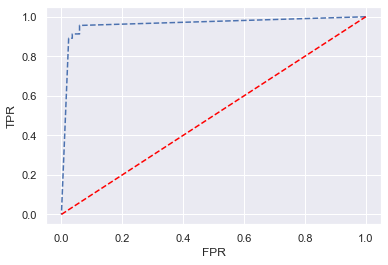

In [3]:
# designing classification metrics by hand
import numpy as np
import seaborn as sns

sns.set()

class_num = 2  # can't be zero
probs = posteriors[:,class_num].reshape(-1,1)
y_test_1 = np.zeros(y_test.shape).astype(int)
y_test_1[y_test==class_num] = 1

# generate ROC
thresholds = np.linspace(0,1,100)
mask = (probs > thresholds)*1 
TPR = np.sum(mask * y_test_1.reshape(-1,1), axis=0) / y_test_1.sum()
FPR = np.sum(mask * (1-y_test_1.reshape(-1,1)), axis=0) / (1 - y_test_1).sum()

# plot ROC
import matplotlib.pyplot as plt
plt.plot(FPR, TPR, linestyle='--')
plt.xlabel('FPR')
plt.plot([0,1],[0,1], linestyle='--', color='red')
plt.ylabel('TPR')
plt.show()

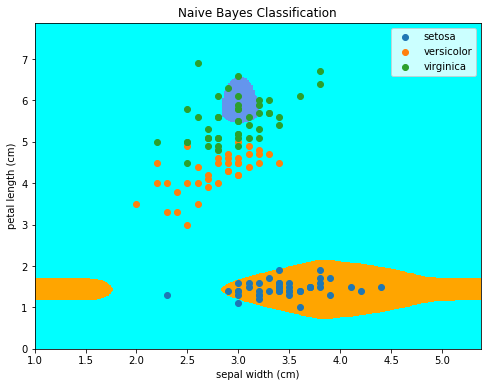

In [57]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


h = 0.02 
feature_1 = 1
feature_2 = 2


# plotting and visualizing the decision boundary
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])

x_min, x_max = X_test[:, feature_1].min() - 1, X_test[:, feature_1].max() + 1
y_min, y_max = X_test[:, feature_2].min() - 1, X_test[:, feature_2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

X_test_n = np.concatenate((np.ones((xx.size,1)), xx.reshape(-1,1),yy.reshape(-1,1), np.ones((xx.size,1))), axis=1)

def bayes_predict(X_test, feature_means, feature_std, priors):
    """Computes naive bayes class predictions for a data"""
    
    # compute per class posteriors for test data
    posteriors = np.zeros((X_test.shape[0], priors.size))

    for i in range(priors.size):
        posteriors[:, i] = np.exp(np.sum(np.log(gaussian(X_test, feature_means[i], feature_std[i]) + 1e-4), axis=1) + np.log(priors[i]))

    # perform inference
    posteriors = (posteriors / np.linalg.norm(posteriors, axis=1).reshape(-1,1))
    y_pred = np.argmax(posteriors, axis=1)
    
    return y_pred

y_pred_n = bayes_predict(X_test_n, feature_means, feature_std, priors)

y_pred_n = y_pred_n.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(8, 6))
ax.contourf(xx, yy, y_pred_n, cmap=cmap_light)

# Plot also the training points
for class_num in np.unique(y_test):
        ax.scatter(X_test[:,1][y_test==class_num], X_test[:,2][y_test==class_num], label = iris.target_names[class_num])


plt.title("Naive Bayes Classification")
plt.xlabel(iris.feature_names[feature_1])
plt.ylabel(iris.feature_names[feature_2])
plt.legend()
plt.show()

In [46]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# define train and test sizes
N_train = 20
N_test = 150 - N_train

# load data
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

# Normalize X
X = (X - np.min(X, axis=0, keepdims=True)) / (np.max(X, axis=0, keepdims=True) - np.min(X, axis=0, keepdims=True))

# append 1 to X for bias
X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, train_size=N_train, random_state=4803)

# initialize theta vector randomly
theta = np.random.randn(X_train.shape[1],1)

# define logistic regression cost function
def logit_cost_func(theta, features, targets):
    """function computes value of cost function given the theta vector, the feature tensor, and corresponding targets"""
    
    return np.sum(targets.reshape(-1,1) * features.dot(theta) - np.log(1 + np.exp(features.dot(theta))))
    

# define gradient function
def logit_grad(theta, features, targets):
    """Function computes the gradient of the logistic regression given the theta vector, the feature tensor, and corresponding targets"""
    
    return features.T.dot(targets.reshape(-1,1) - 1 / (1 + np.exp(features.dot(theta))))


# define gradient descent attributes
step = 5 
epochs = 20

# start training
for epoch in range(epochs):
    print("Epoch: [%d/%d]"%(epoch, epochs), "| Function value: %.2f" %logit_cost_func(theta, X_train, y_train))
    theta = theta - step * logit_grad(theta, X_train, y_train)

# perform inference
y_pred = np.zeros(y_test.shape).reshape(-1,1).astype(int)
probs = 1 / (1 + np.exp(X_test.dot(theta)))
y_pred[probs > 0.5] = 1

# compute accuracy
print("\nAccuracy: %.2f"%accuracy_score(y_test.ravel(), y_pred.ravel()))

Epoch: [0/20] | Function value: -18.33
Epoch: [1/20] | Function value: -721.53
Epoch: [2/20] | Function value: -1099.69
Epoch: [3/20] | Function value: -1290.48
Epoch: [4/20] | Function value: -927.90
Epoch: [5/20] | Function value: -1859.44
Epoch: [6/20] | Function value: -993.11
Epoch: [7/20] | Function value: -1009.07
Epoch: [8/20] | Function value: -966.27
Epoch: [9/20] | Function value: -1000.11
Epoch: [10/20] | Function value: -996.91
Epoch: [11/20] | Function value: -996.29
Epoch: [12/20] | Function value: -995.85
Epoch: [13/20] | Function value: -995.50
Epoch: [14/20] | Function value: -995.21
Epoch: [15/20] | Function value: -994.97
Epoch: [16/20] | Function value: -994.75
Epoch: [17/20] | Function value: -994.56
Epoch: [18/20] | Function value: -994.39
Epoch: [19/20] | Function value: -994.24

Accuracy: 0.88


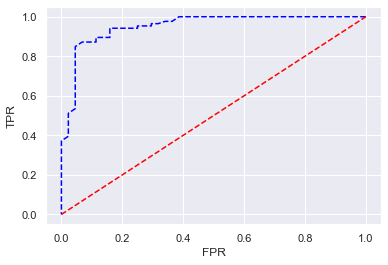

In [39]:
# designing classification metrics by hand
import numpy as np

# generate ROC
thresholds = np.linspace(0,1,100)
mask = (probs > thresholds)*1 
TPR = np.sum(mask * y_test.reshape(-1,1), axis=0) / y_test.sum()
FPR = np.sum(mask * (1-y_test.reshape(-1,1)), axis=0) / (1 - y_test).sum()

# plot ROC
import matplotlib.pyplot as plt
plt.plot(FPR, TPR, linestyle='--', color='blue'), plt.plot([0,1],[0,1], linestyle='--', color='red'), plt.xlabel('FPR'), plt.ylabel('TPR')
plt.show()



# Using Classes to set up Models
---


Epoch: [0/20] | Function value: -14.59
Epoch: [1/20] | Function value: -53.44
Epoch: [2/20] | Function value: -174.11
Epoch: [3/20] | Function value: -48.35
Epoch: [4/20] | Function value: -96.39
Epoch: [5/20] | Function value: -111.95
Epoch: [6/20] | Function value: -161.04
Epoch: [7/20] | Function value: -104.00
Epoch: [8/20] | Function value: -116.75
Epoch: [9/20] | Function value: -107.07
Epoch: [10/20] | Function value: -114.91
Epoch: [11/20] | Function value: -107.96
Epoch: [12/20] | Function value: -113.92
Epoch: [13/20] | Function value: -110.29
Epoch: [14/20] | Function value: -112.65
Epoch: [15/20] | Function value: -112.19
Epoch: [16/20] | Function value: -113.01
Epoch: [17/20] | Function value: -113.35
Epoch: [18/20] | Function value: -113.86
Epoch: [19/20] | Function value: -114.30

True Positive Rate: 0.94
False Positive Rate: 0.05


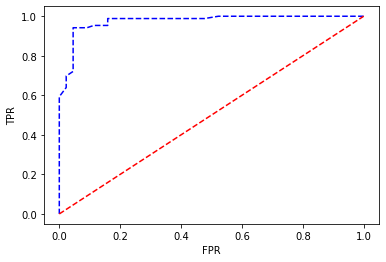

In [8]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

class MyLogisticRegression:    
    def __init__(self, X, y):       
        self.X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        self.y = y
        self.theta  = np.random.randn(self.X.shape[1],1)
        
    # define logistic regression cost function
    def logit_cost_func(self, theta, features, targets):
        """function computes value of cost function given the theta vector, the feature tensor, and corresponding targets"""
    
        return np.sum(targets.reshape(-1,1) * features.dot(theta) - np.log(1 + np.exp(features.dot(theta))))
    

    # define gradient function
    def logit_grad(self, theta, features, targets):
        """Function computes the gradient of the logistic regression given the theta vector, the feature tensor, and corresponding targets"""
    
        return features.T.dot(targets.reshape(-1,1) - 1 / (1 + np.exp(features.dot(theta))))
    
    
    def normalize_data(self, X):
        X = (X - np.min(X, axis=0, keepdims=True)) / (np.max(X, axis=0, keepdims=True) - np.min(X, axis=0, keepdims=True))
        return X
    
    def fit(self, num_epochs=20, step=2):
        for epoch in range(num_epochs):
            print("Epoch: [%d/%d]"%(epoch, num_epochs), "| Function value: %.2f" % self.logit_cost_func(self.theta, self.X, self.y))
            self.theta = self.theta - step * self.logit_grad(self.theta, self.X, self.y) / self.X.shape[0]
            
            
    def predict(self, X):        
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        y_pred = np.zeros(X.shape[0]).reshape(-1,1).astype(int)
        probs = 1 / (1 + np.exp(X.dot(self.theta)))
        y_pred[probs > 0.5] = 1
        
        return y_pred, probs
 

def roc(probs, y_test):
    """Function returns TPR and FPR given a vector of probabilities and another 
    for ground-truth predictions"""
    
    thresholds = np.linspace(0,1,100)
    mask = (probs > thresholds)*1 
    TPR = np.sum(mask * y_test.reshape(-1,1), axis=0) / y_test.sum()
    FPR = np.sum(mask * (1-y_test.reshape(-1,1)), axis=0) / (1 - y_test).sum()
    
    return TPR, FPR


# define train and test sizes
N_train = 20
N_test = 150 - N_train

# load data
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

# Normalize X
X = (X - np.min(X, axis=0, keepdims=True)) / (np.max(X, axis=0, keepdims=True) - np.min(X, axis=0, keepdims=True))

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, train_size=N_train, random_state=4803)

# train model and predict on test data
model =  MyLogisticRegression(X_train, y_train)
model.fit(num_epochs = 20, step=10)
y_pred, probs = model.predict(X_test)

# compute accuracy
print("\nTrue Positive Rate: %.2f" % (np.sum(y_pred.reshape(-1,1) * y_test.reshape(-1,1))/np.sum(y_test)))
print("False Positive Rate: %.2f" % (np.sum(y_pred.reshape(-1,1) * (1 - y_test).reshape(-1,1))/np.sum(1 - y_test)))

# plot ROC
TPR, FPR = roc(probs, y_test)
plt.plot(FPR, TPR, linestyle='--', color='blue') 
plt.plot([0,1],[0,1], linestyle='--', color='red') 
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()


# Effect of Training Set Size on ROC 

In [49]:
# implement naive bayes class

import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class MyNaiveBayes:
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    
    def gaussian(self, x, mean, std):
        return 1/(std*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mean)/std)**2)
    
    
    def fit(self):
        # calculate class priors from train data
        self.priors = (np.bincount(self.y_train)/self.y_train.size).reshape(-1,1)
        
        # calculate per class data likelihoods
        self.feature_means = np.zeros((self.priors.size,1,self.X_train.shape[1]))
        self.feature_std = np.zeros((self.priors.size,1,self.X_train.shape[1]))
        
        for i in range(self.priors.size):
            self.feature_means[i] = np.mean(self.X_train[self.y_train == i], axis=0).reshape(1,-1)
            self.feature_std[i] = np.std(self.X_train[self.y_train == i], axis=0).reshape(1,-1)

    
    def predict(self, X_test):
        # compute per class posteriors for test data
        posteriors = np.zeros((X_test.shape[0], self.priors.size))

        for i in range(self.priors.size):
            posteriors[:, i] = np.exp(np.sum(np.log(self.gaussian(X_test, self.feature_means[i], self.feature_std[i]) + 1e-4), axis=1) + np.log(self.priors[i]))

        # perform inference
        posteriors = (posteriors / np.linalg.norm(posteriors, axis=1).reshape(-1,1))
        y_pred = np.argmax(posteriors, axis=1)
        
        return y_pred, posteriors


# define train and test sizes
N_train = 20
N_test = 150 - N_train

# load data
iris = load_iris()
X, y = iris.data, iris.target

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, train_size=N_train, random_state=4803)

model = MyNaiveBayes(X_train, y_train)
model.fit()
y_pred, _ = model.predict(X_test)
    
print("Accuracy Score: %.3f" % accuracy_score(y_test, y_pred))    

Accuracy Score: 0.938


Epoch: [0/20] | Function value: -3.39
Epoch: [1/20] | Function value: -10.66
Epoch: [2/20] | Function value: -13.27
Epoch: [3/20] | Function value: -13.87
Epoch: [4/20] | Function value: -16.87
Epoch: [5/20] | Function value: -15.34
Epoch: [6/20] | Function value: -19.28
Epoch: [7/20] | Function value: -18.65
Epoch: [8/20] | Function value: -19.68
Epoch: [9/20] | Function value: -20.12
Epoch: [10/20] | Function value: -20.50
Epoch: [11/20] | Function value: -20.86
Epoch: [12/20] | Function value: -21.20
Epoch: [13/20] | Function value: -21.51
Epoch: [14/20] | Function value: -21.81
Epoch: [15/20] | Function value: -22.08
Epoch: [16/20] | Function value: -22.35
Epoch: [17/20] | Function value: -22.60
Epoch: [18/20] | Function value: -22.84
Epoch: [19/20] | Function value: -23.07

True Positive Rate: 0.99
False Positive Rate: 0.98
Epoch: [0/20] | Function value: -36.19
Epoch: [1/20] | Function value: -58.83
Epoch: [2/20] | Function value: -209.24
Epoch: [3/20] | Function value: -231.22
E

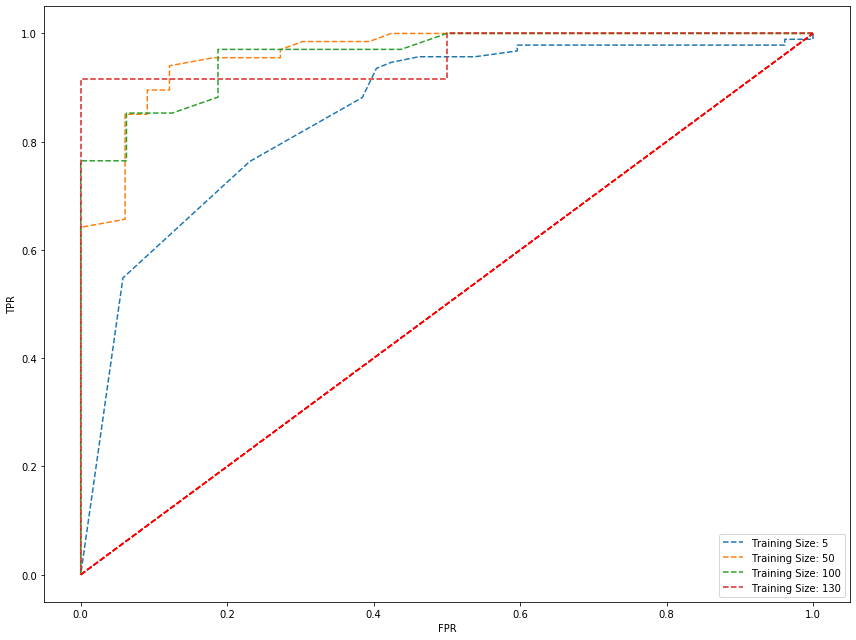

In [14]:
training_set_sizes = [5, 50, 100, 130]

fig, ax = plt.subplots(figsize=(12,9))

for train_size in training_set_sizes:
    
    # define train and test sizes
    N_train = train_size
    N_test = 150 - N_train

    # load data
    cancer = load_breast_cancer()
    X, y = cancer.data, cancer.target

    # Normalize X
    X = (X - np.min(X, axis=0, keepdims=True)) / (np.max(X, axis=0, keepdims=True) - np.min(X, axis=0, keepdims=True))

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, train_size=N_train, random_state=4803)

    # train model and predict on test data
    model =  MyLogisticRegression(X_train, y_train)
    model.fit(num_epochs = 20, step=10)
    y_pred, probs = model.predict(X_test)

    # compute accuracy
    print("\nTrue Positive Rate: %.2f" % (np.sum(y_pred.reshape(-1,1) * y_test.reshape(-1,1))/np.sum(y_test)))
    print("False Positive Rate: %.2f" % (np.sum(y_pred.reshape(-1,1) * (1 - y_test).reshape(-1,1))/np.sum(1 - y_test)))

    # plot ROC
    TPR, FPR = roc(probs, y_test)
    ax.plot(FPR, TPR, linestyle='--', label='Training Size: %d' % N_train) 
    ax.plot([0,1],[0,1], linestyle='--', color='red') 
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')

plt.legend()
plt.tight_layout()
plt.show()    

In [32]:
# Use sklearn

import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# define train and test sizes
N_train = 20
N_test = 150 - N_train

# load data
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

# Normalize X
X = (X - np.min(X, axis=0, keepdims=True)) / (np.max(X, axis=0, keepdims=True) - np.min(X, axis=0, keepdims=True))

# append 1 to X for bias
X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, train_size=N_train, random_state=4803)

# set up model
model = LogisticRegression()

# train and test
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print accuracy
print("Accuracy: %.2f"%accuracy_score(y_test.ravel(), y_pred.ravel()))


Accuracy: 0.88
